In [76]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.decomposition import PCA
%matplotlib inline
plt.style.use('seaborn')

In [77]:
# Set display options for better notebook visualization
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [78]:
# Function to handle datetime conversion safely
def safe_datetime_convert(x):
    try:
        return pd.to_datetime(x)
    except:
        return pd.NaT

In [79]:
# Function for clustering metrics
def calculate_metrics(data, labels):
    db_index = davies_bouldin_score(data, labels)
    silhouette = silhouette_score(data, labels)
    return db_index, silhouette

In [80]:
# Data Loading
print("Loading datasets...")
try:
    customers_df = pd.read_csv('Customers.csv')
    transactions_df = pd.read_csv('Transactions.csv')
    print("Data loaded successfully!")
except Exception as e:
    print(f"Error loading data: {e}")
    raise

Loading datasets...
Data loaded successfully!


In [81]:
# Display initial data info
print("\nInitial data shape:")
print(f"Customers: {customers_df.shape}")
print(f"Transactions: {transactions_df.shape}")


Initial data shape:
Customers: (200, 4)
Transactions: (1000, 7)


In [82]:
# Data Preprocessing
print("\nPreprocessing data...")


Preprocessing data...


In [83]:
# Process customer data
customers_df['SignupDate'] = customers_df['SignupDate'].apply(safe_datetime_convert)
customers_df['AccountAge'] = (pd.Timestamp('now') - customers_df['SignupDate']).dt.days

In [84]:
# Create customer features from transactions
transaction_features = transactions_df.groupby('CustomerID').agg({
    'TransactionID': 'count',
    'TotalValue': ['sum', 'mean', 'std'],
    'Quantity': ['sum', 'mean', 'std']
})

In [85]:
# Flatten column names
transaction_features.columns = ['transaction_count', 'total_spend', 'avg_transaction_value', 
                              'std_transaction_value', 'total_quantity', 'avg_quantity', 
                              'std_quantity']

In [86]:
# Handle NaN values in transaction features
transaction_features = transaction_features.fillna(0)

In [87]:
# Calculate recency
latest_transaction_date = transactions_df.groupby('CustomerID')['TransactionDate'].max()
latest_transaction_date = pd.to_datetime(latest_transaction_date)
recency = (pd.Timestamp('now') - latest_transaction_date).dt.days
transaction_features['recency'] = recency

In [88]:
# Merge features
customer_features = customers_df[['CustomerID', 'AccountAge', 'Region']].set_index('CustomerID')
customer_features = pd.get_dummies(customer_features, columns=['Region'])
features_df = customer_features.join(transaction_features)

In [89]:
# Handle any remaining missing values
features_df = features_df.fillna(0)
features_df = features_df.replace([np.inf, -np.inf], np.nan)
features_df = features_df.fillna(features_df.mean())

print("\nFeature engineering completed.")
print("Features shape:", features_df.shape)
print("\nChecking for NaN values:", features_df.isna().sum().sum())
print("Checking for infinite values:", np.isinf(features_df.values).sum())


Feature engineering completed.
Features shape: (200, 13)

Checking for NaN values: 0
Checking for infinite values: 0


In [90]:
# Feature Scaling
print("\nScaling features...")
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_df)
scaled_features_df = pd.DataFrame(scaled_features, columns=features_df.columns, 
                                index=features_df.index)


Scaling features...


In [91]:
# Verify scaled features
print("Scaled features shape:", scaled_features_df.shape)
print("Checking scaled features for NaN:", np.isnan(scaled_features_df.values).sum())
print("Checking scaled features for infinite values:", np.isinf(scaled_features_df.values).sum())

Scaled features shape: (200, 13)
Checking scaled features for NaN: 0
Checking scaled features for infinite values: 0


In [92]:
# Finding Optimal Clusters
print("\nCalculating clustering metrics for different numbers of clusters...")
n_clusters_range = range(2, 11)
metrics = []

for n_clusters in n_clusters_range:
    print(f"Testing {n_clusters} clusters...")
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(scaled_features)
    db_index, silhouette = calculate_metrics(scaled_features, cluster_labels)
    metrics.append({
        'n_clusters': n_clusters,
        'db_index': db_index,
        'silhouette': silhouette
    })

metrics_df = pd.DataFrame(metrics)


Calculating clustering metrics for different numbers of clusters...
Testing 2 clusters...
Testing 3 clusters...
Testing 4 clusters...
Testing 5 clusters...
Testing 6 clusters...
Testing 7 clusters...
Testing 8 clusters...
Testing 9 clusters...
Testing 10 clusters...


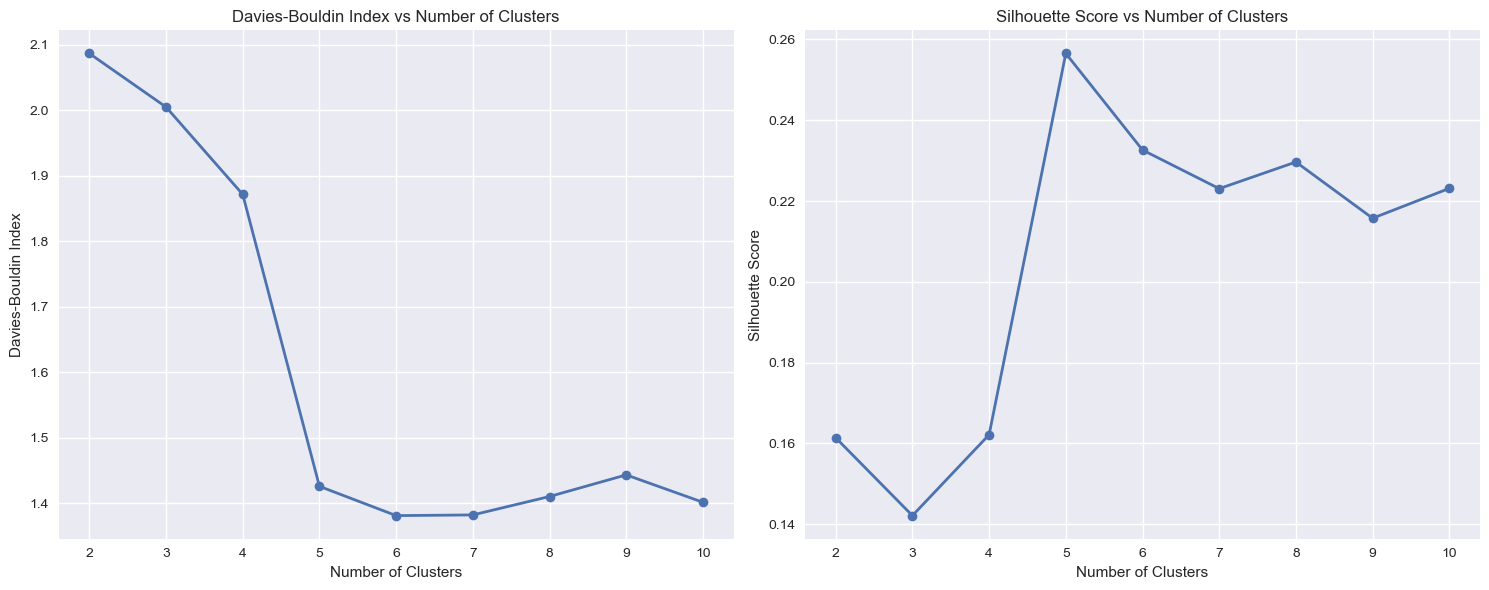

In [93]:
# Plotting metrics
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(metrics_df['n_clusters'], metrics_df['db_index'], marker='o', linewidth=2)
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index vs Number of Clusters')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(metrics_df['n_clusters'], metrics_df['silhouette'], marker='o', linewidth=2)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.grid(True)

plt.tight_layout()
plt.show()

In [94]:
# Display metrics table
print("\nClustering Metrics for Different Numbers of Clusters:")
print(metrics_df.to_string(index=False))


Clustering Metrics for Different Numbers of Clusters:
 n_clusters  db_index  silhouette
          2     2.087       0.161
          3     2.005       0.142
          4     1.871       0.162
          5     1.426       0.257
          6     1.381       0.233
          7     1.382       0.223
          8     1.410       0.230
          9     1.443       0.216
         10     1.401       0.223


In [95]:
# Final Clustering
optimal_clusters = metrics_df.loc[metrics_df['silhouette'].idxmax(), 'n_clusters']
print(f"\nOptimal number of clusters based on Silhouette Score: {optimal_clusters}")

final_kmeans = KMeans(n_clusters=int(optimal_clusters), random_state=42, n_init=10)
cluster_labels = final_kmeans.fit_predict(scaled_features)


Optimal number of clusters based on Silhouette Score: 5


In [96]:
# Add cluster labels to original data
features_df['Cluster'] = cluster_labels

In [97]:
# Analyze clusters
print("\nCluster Characteristics:")
cluster_summary = features_df.groupby('Cluster').agg({
    'transaction_count': 'mean',
    'total_spend': 'mean',
    'avg_transaction_value': 'mean',
    'recency': 'mean',
    'AccountAge': 'mean'
}).round(2)

print(cluster_summary)


Cluster Characteristics:
         transaction_count  total_spend  avg_transaction_value  recency  \
Cluster                                                                   
0                    4.890     3617.580                747.410  102.310   
1                    5.460     4011.690                731.390   92.480   
2                    5.600     3508.420                650.850  103.580   
3                    1.750      631.200                416.200  191.850   
4                    5.500     3870.730                720.770   86.660   

         AccountAge  
Cluster              
0           583.040  
1           635.020  
2           467.840  
3           460.800  
4           580.740  


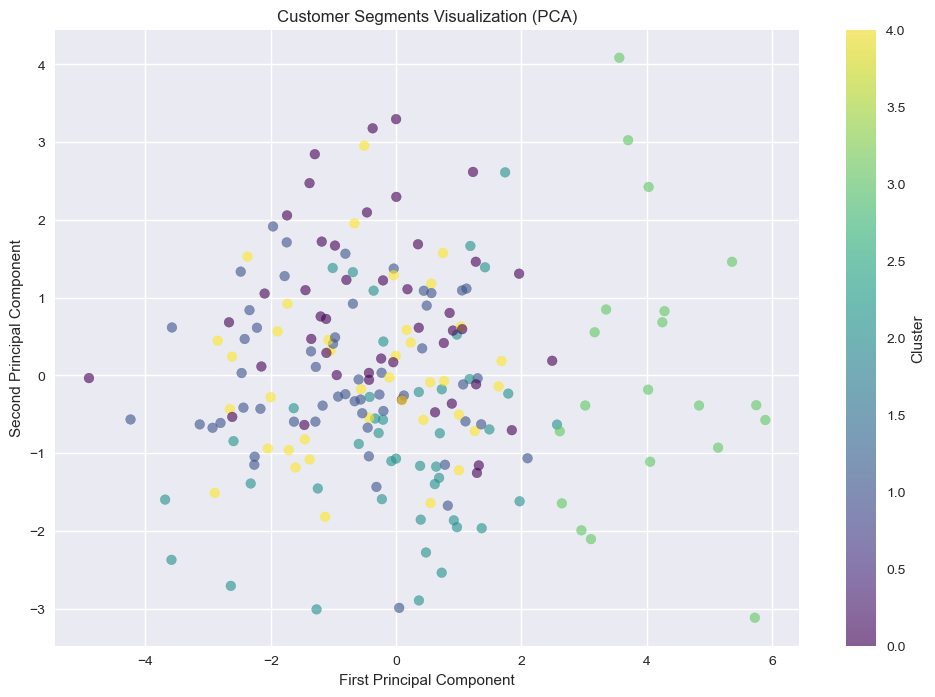

In [98]:
# Cluster Visualization
# PCA visualization
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(pca_features[:, 0], pca_features[:, 1], 
                     c=cluster_labels, 
                     cmap='viridis',
                     alpha=0.6)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('Customer Segments Visualization (PCA)')
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.show()

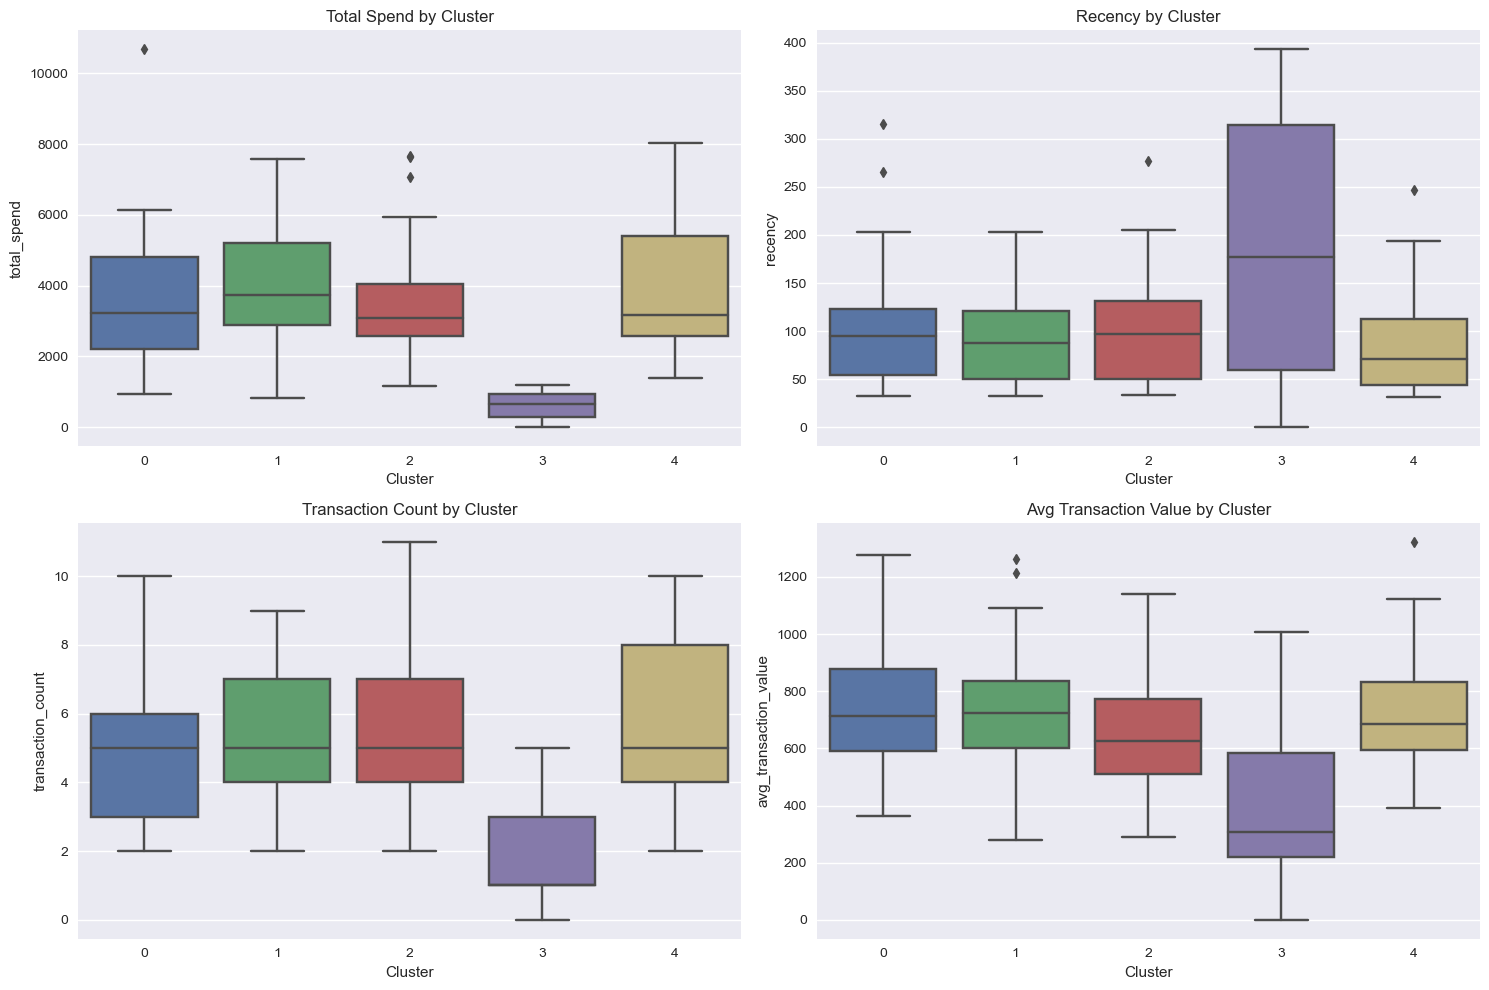

In [99]:
# Feature distributions by cluster
plt.figure(figsize=(15, 10))
for i, feature in enumerate(['total_spend', 'recency', 'transaction_count', 'avg_transaction_value']):
    plt.subplot(2, 2, i+1)
    sns.boxplot(x='Cluster', y=feature, data=features_df)
    plt.title(f'{feature.replace("_", " ").title()} by Cluster')
plt.tight_layout()
plt.show()

In [100]:
# Final Metrics
final_db_index, final_silhouette = calculate_metrics(scaled_features, cluster_labels)
print("\nFinal Clustering Metrics:")
print(f"Davies-Bouldin Index: {final_db_index:.3f}")
print(f"Silhouette Score: {final_silhouette:.3f}")


Final Clustering Metrics:
Davies-Bouldin Index: 1.426
Silhouette Score: 0.257


In [101]:
# Cluster Size Analysis
cluster_sizes = features_df['Cluster'].value_counts().sort_index()
print("\nCluster Sizes:")
print(cluster_sizes)


Cluster Sizes:
0    45
1    54
2    43
3    20
4    38
Name: Cluster, dtype: int64


In [102]:
# Save Results
# Create output directory if it doesn't exist
import os
if not os.path.exists('clustering_results'):
    os.makedirs('clustering_results')

In [103]:
# Save results with timestamps
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
cluster_summary.to_csv(f'clustering_results/cluster_summary_{timestamp}.csv')
features_df['Cluster'].to_csv(f'clustering_results/customer_clusters_{timestamp}.csv')
metrics_df.to_csv(f'clustering_results/clustering_metrics_{timestamp}.csv')

print("\nResults saved in 'clustering_results' directory")


Results saved in 'clustering_results' directory


In [104]:
# Calculate cluster profiles
print("\nCluster Profiles:")
for cluster in range(int(optimal_clusters)):
    cluster_data = features_df[features_df['Cluster'] == cluster]
    print(f"\nCluster {cluster} Profile:")
    print(f"Size: {len(cluster_data)} customers ({(len(cluster_data)/len(features_df)*100):.1f}%)")
    print("Average characteristics:")
    for col in ['transaction_count', 'total_spend', 'avg_transaction_value', 'recency']:
        print(f"{col.replace('_', ' ').title()}: {cluster_data[col].mean():.2f}")


Cluster Profiles:

Cluster 0 Profile:
Size: 45 customers (22.5%)
Average characteristics:
Transaction Count: 4.89
Total Spend: 3617.58
Avg Transaction Value: 747.41
Recency: 102.31

Cluster 1 Profile:
Size: 54 customers (27.0%)
Average characteristics:
Transaction Count: 5.46
Total Spend: 4011.69
Avg Transaction Value: 731.39
Recency: 92.48

Cluster 2 Profile:
Size: 43 customers (21.5%)
Average characteristics:
Transaction Count: 5.60
Total Spend: 3508.42
Avg Transaction Value: 650.85
Recency: 103.58

Cluster 3 Profile:
Size: 20 customers (10.0%)
Average characteristics:
Transaction Count: 1.75
Total Spend: 631.20
Avg Transaction Value: 416.20
Recency: 191.85

Cluster 4 Profile:
Size: 38 customers (19.0%)
Average characteristics:
Transaction Count: 5.50
Total Spend: 3870.73
Avg Transaction Value: 720.77
Recency: 86.66
